In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import pylab as pl
import plotly.express as px

In [2]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models = {}

In [3]:
#Costruisco il dizionario models con il nome del modello, il nomde del percorso di tutti i file *.nc di ogni modello e il nome di .nc, cioè il modello remapbil

#Percorso dei file
name_models = '/work/users/guest/sbeltrami/prova/name_atmos_model.txt'
path_models = '/work/users/guest/sbeltrami/prova/path_atmos_model.txt'
path_remap_models = '/work/users/guest/sbeltrami/prova/path_remap_atmos_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models = file.readlines()
with open(path_models, 'r') as file:
    lines_path_models = file.readlines()
with open(path_remap_models, 'r') as file:
    lines_path_remap_models = file.readlines()

In [4]:
# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap in zip(lines_name_models, lines_path_models, lines_path_remap_models): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models:
        models[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models[model_name]['name'] = model_name
    models[model_name]['path'] = line_path.strip()
    models[model_name]['path remap'] = line_path_remap.strip()
for name in models.keys():
    path_remap = models[name]['path remap']
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models[name]['dataset'] = xr.open_dataset(path_remap)
        dataset = models[name]['dataset']
        #peso il dataset
        models[name]['dataset weighted'] = compute_dataset_weighted(dataset["ua"])
        #medie annuali con dataset pesato
        models[name]['dataset annual mean'] = compute_annual_mean_weighted(models[name]['dataset weighted'])
        print(models[name]['name']) 

        #Seleziono il box del Nord Atlantico
        models[name]['North Atlantic box'] = dataset.sel(lon=slice(280,360), lat=slice(30,70))
        na_box = models[name]['North Atlantic box']
        #peso il dataset Nord Atlantico
        models[name]['North Atlantic dataset weighted'] = compute_dataset_weighted(na_box["ua"])
        #calcolo la media annuale del dataset Nord Atlantico
        models[name]['North Atlantic annual mean weighted'] = compute_annual_mean_weighted(models[name]['North Atlantic dataset weighted'])
        #Seleziono la climatologia
        na_box_climat = na_box.sel(time=slice("1984-01", "2014-12"))
        #peso il dataset del periodo scelto per la climatologia
        models[name]['North Atlantic climatology weighted'] = compute_dataset_weighted(na_box_climat["ua"])
        #calcolo la media annuale del dataset na sul periodo scelto
        models[name]['North Atlantic annual mean climatology'] = compute_annual_mean_weighted(models[name]['North Atlantic climatology weighted'])
        #Calcolo l'anomalia di ua rispetto alla climatologia scelta
        models[name]['North Atlantic anomaly'] = compute_anomaly(models[name]['North Atlantic annual mean weighted'],models[name]['North Atlantic annual mean climatology'])
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
E3SM-1-1
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorCPM1
NorESM2-LM
NorESM2-MM
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


In [5]:
#Creo una lista con il nome dei modelli
models_list = list(models.keys())

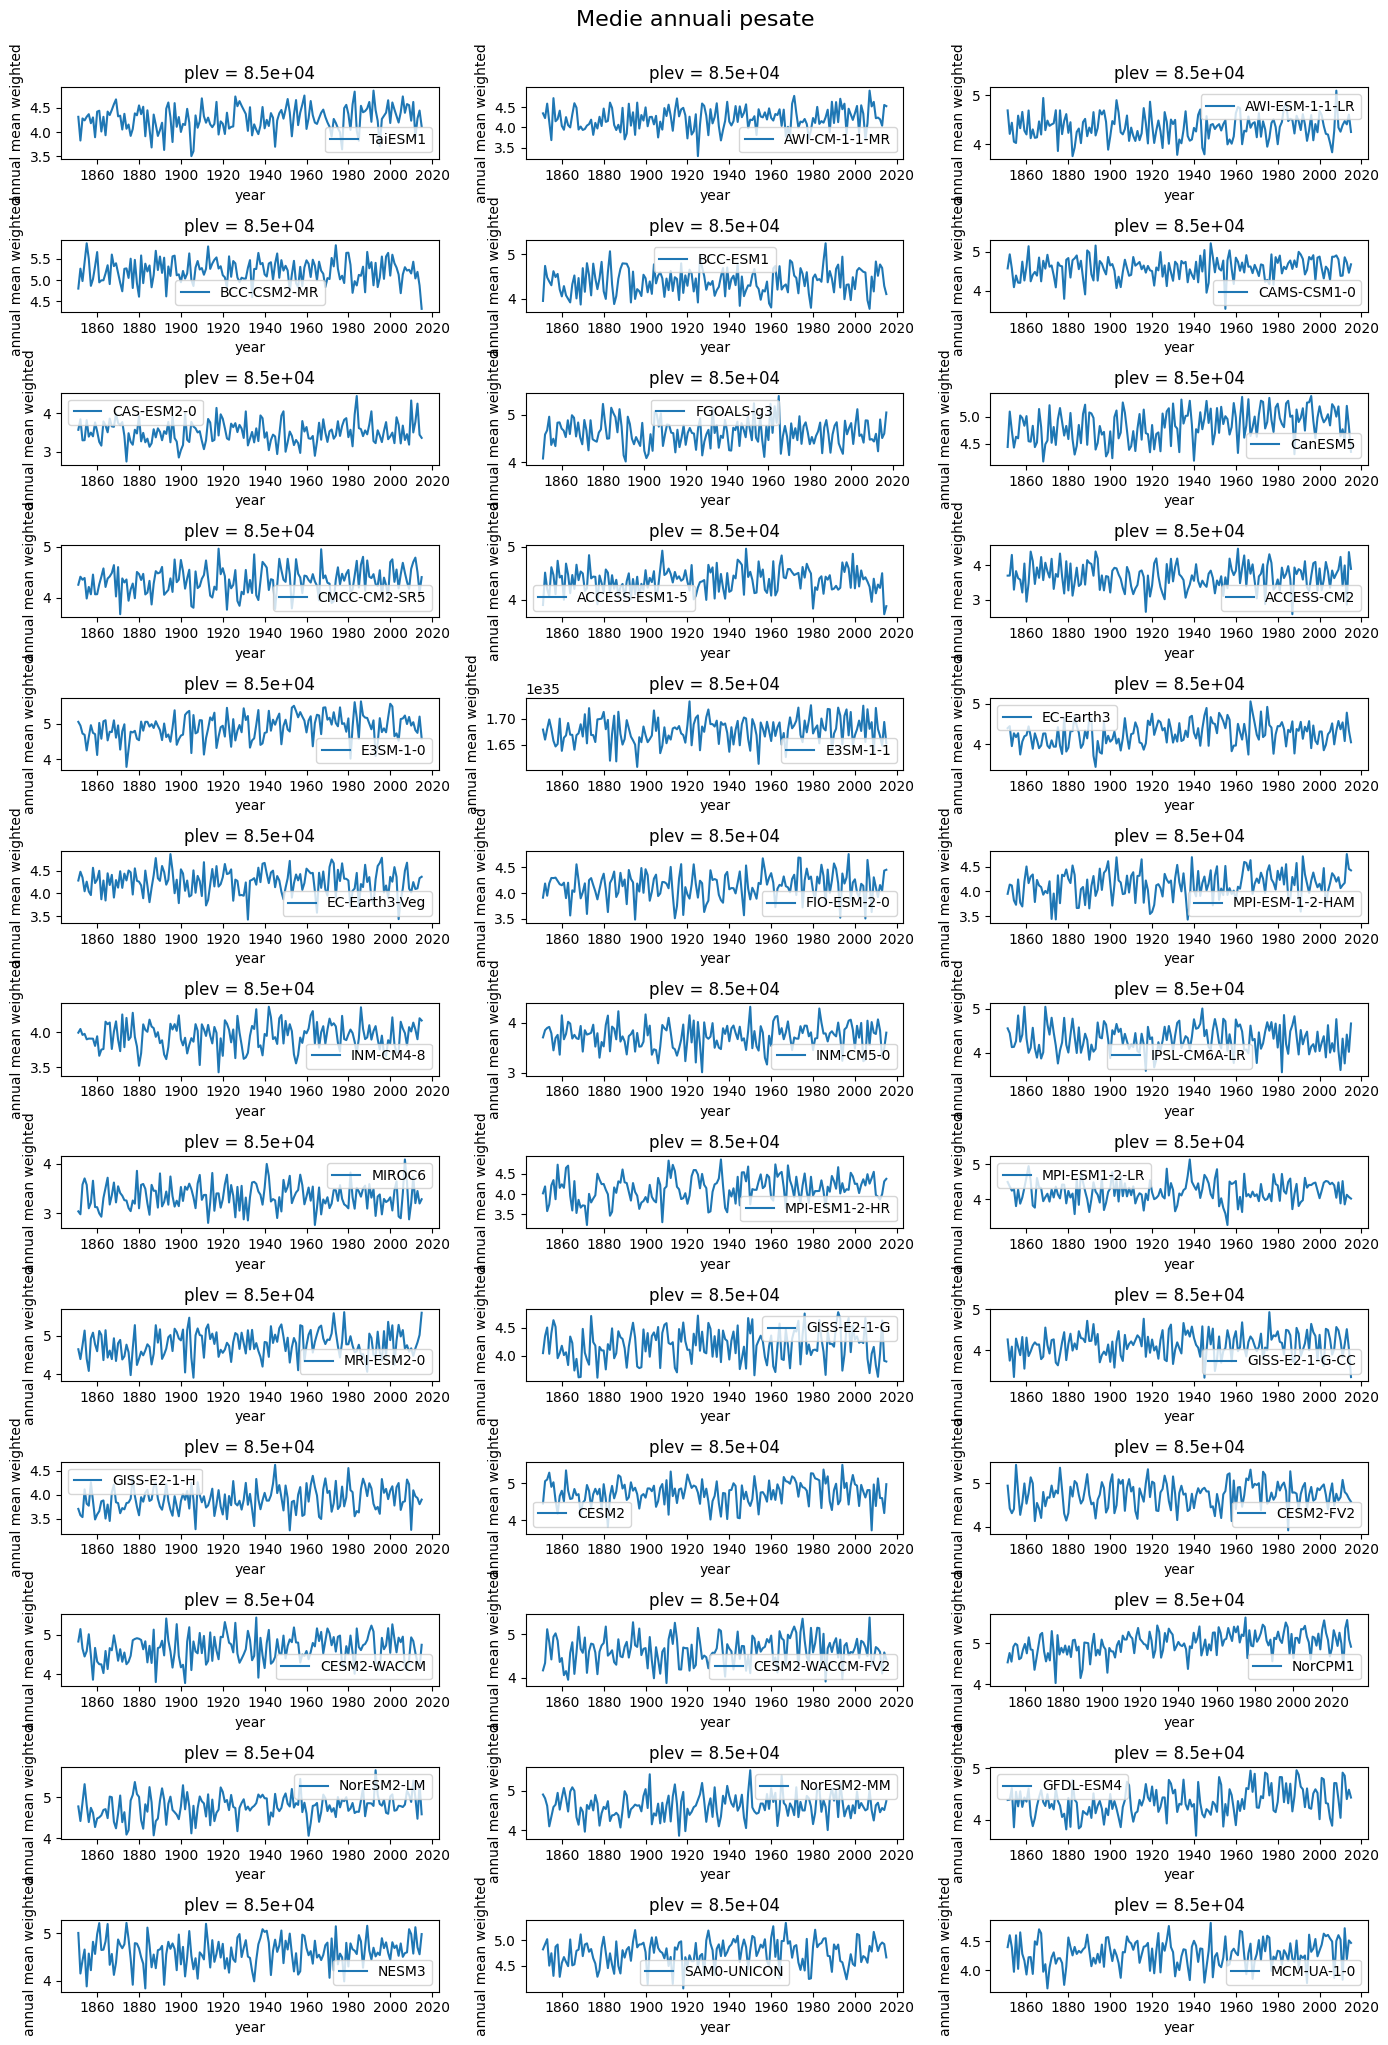

In [6]:
#plot medie annuali dei modelli
fig, ax = plt.subplots(nrows=(int(len(models)/3)),ncols=3,figsize=(14,20))
# Plot dei modelli
for i in range(int(len(models)/3)): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic annual mean weighted'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('annual mean weighted')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Medie annuali pesate', fontsize=16, y=1.02)

plt.savefig('atmos_annual_mean_weighted.pdf', format='pdf')

In [7]:
#Nord Atlantico
#Creo una lista con il nome dei modelli
models_list = list(models.keys())

Nord Atlantico anomalie - Dataset ERA5

Text(0.5, 0.98, 'Anomalia Nord Atlantico ERA rispetto alla media climatologica 1984 - 2014')

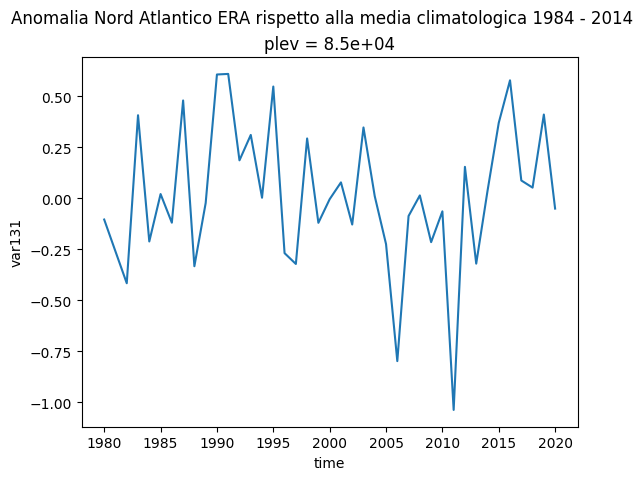

In [12]:
#ERA5 box Nord Atlantico
dataset_ERA_na=xr.open_dataset('/work/users/guest/sbeltrami/prova/ERA5_remap.nc').sel(lon=slice(280,360), lat=slice(30,70)) #seleziono lon lat del Nord Atlantico
#dataset pesato
dataset_ERA_weighted_na = compute_dataset_weighted(dataset_ERA_na["var131"])
#media annuale Nord Atlantico
annual_mean_era_na = compute_annual_mean_weighted(dataset_ERA_weighted_na)
#Scelgo periodo su cui calcolare la climatologia
era_na_1984_2014 = dataset_ERA_na.sel(time=slice("1984-01", "2014-12"))
#peso il dataset del periodo scelto
era_na_1984_2014_weighted = compute_dataset_weighted(era_na_1984_2014["var131"])
#calcolo la media annuale sul periodo scelto
annual_mean_era_na_30 = compute_annual_mean_weighted(era_na_1984_2014_weighted)
#Calcolo l'anomalia di tos rispetto al periodo di riferimento scelto
anomaly_era = compute_anomaly(annual_mean_era_na,annual_mean_era_na_30)
#plot
anomaly_era.plot()
plt.suptitle('Anomalia Nord Atlantico ERA rispetto alla media climatologica 1984 - 2014')

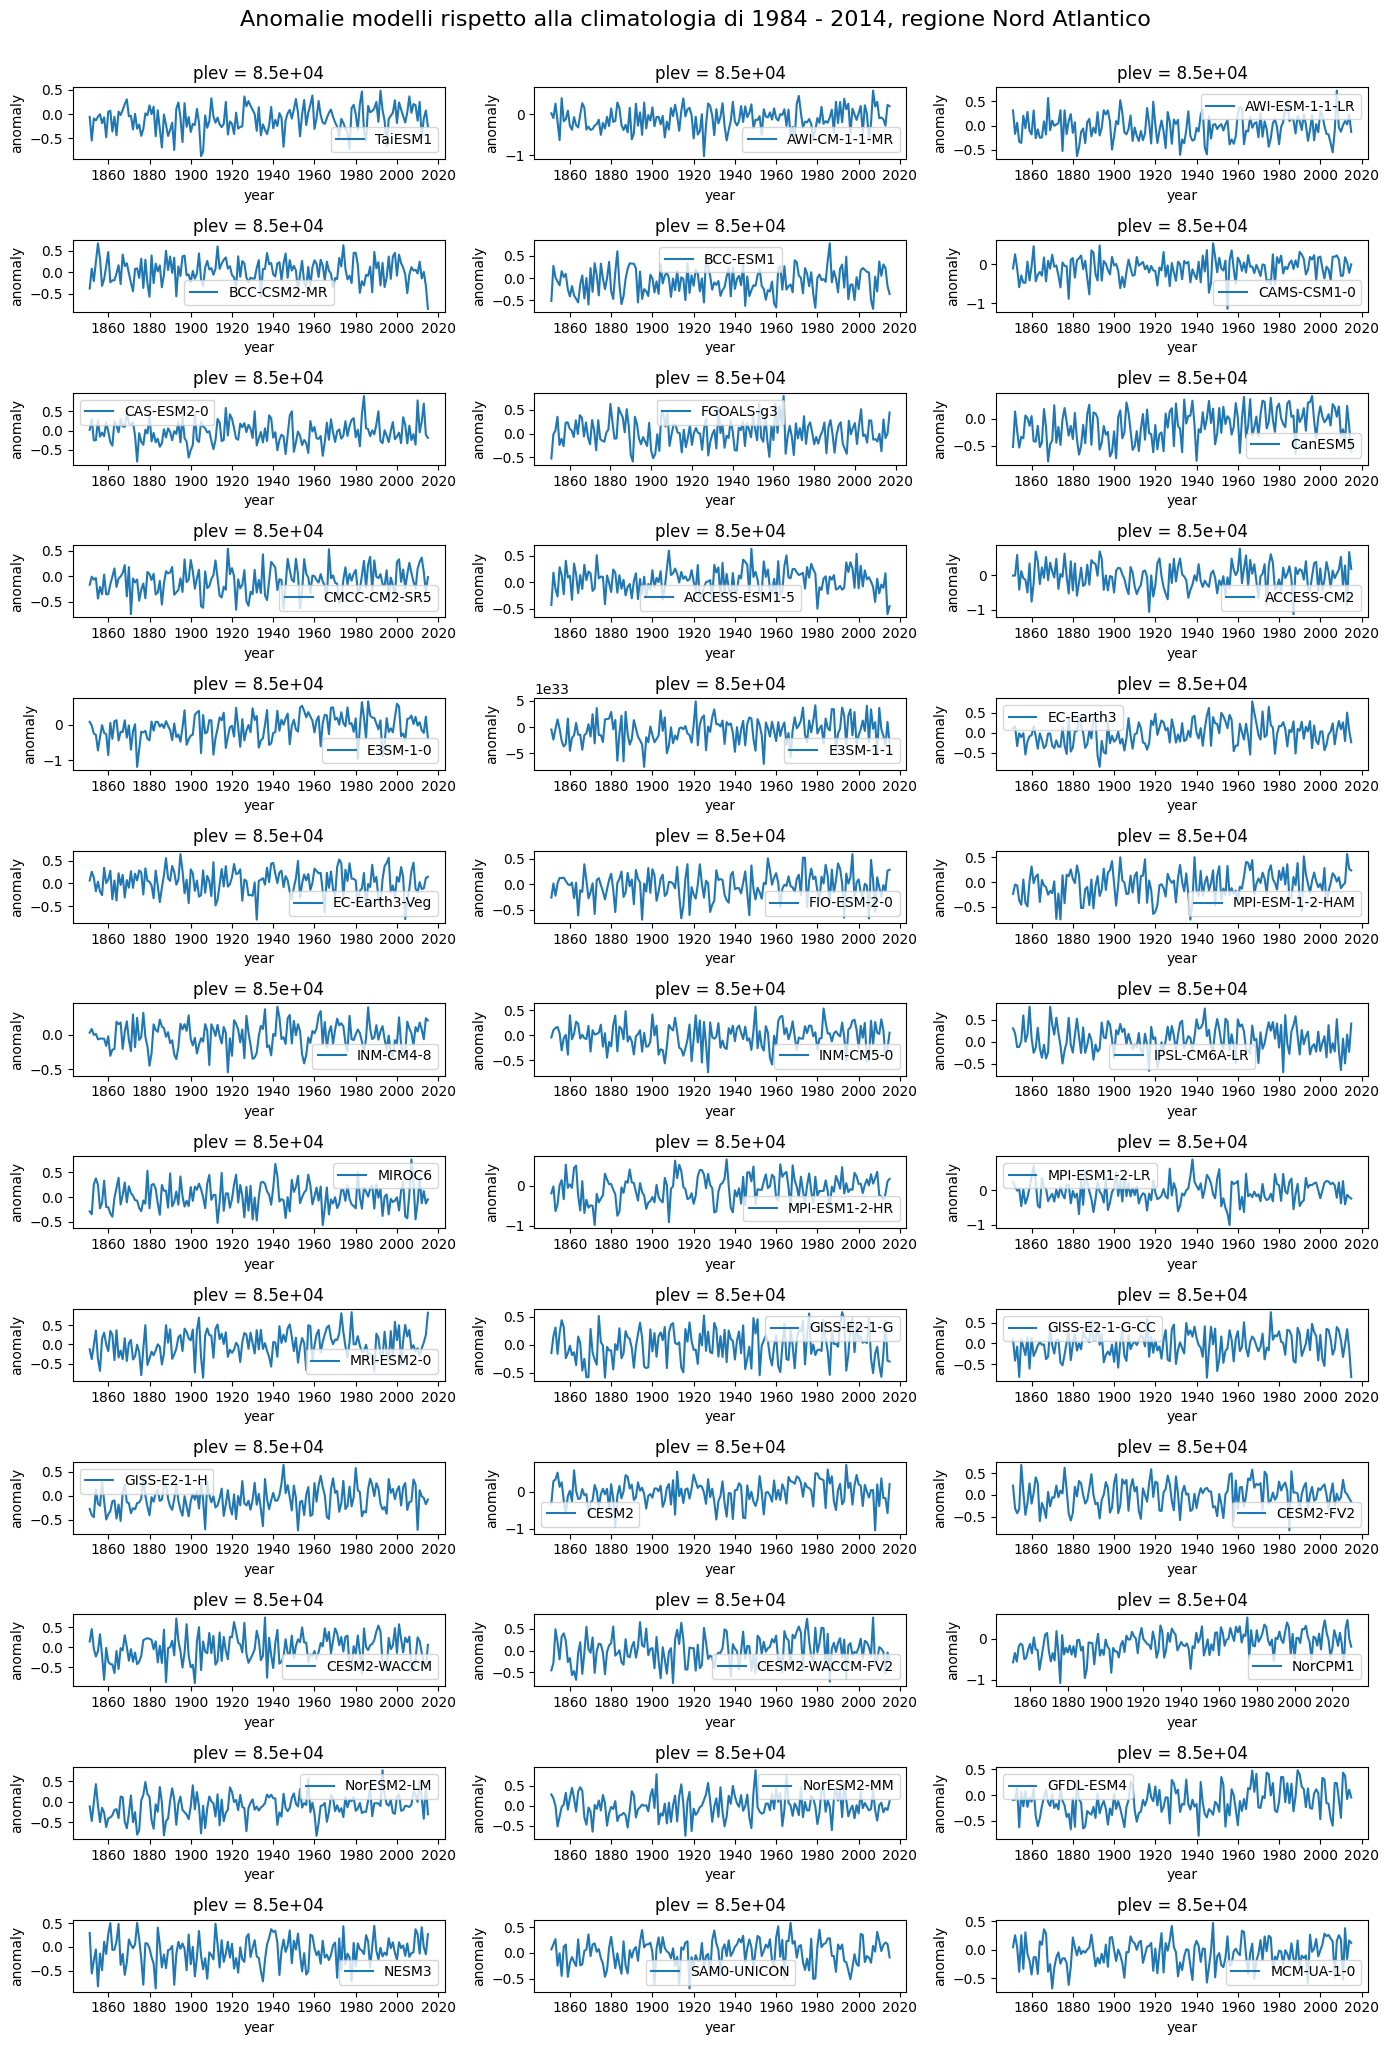

In [13]:
#Plot delle anomalie dei modelli
fig, ax = plt.subplots(nrows=(int(len(models)/3)),ncols=3,figsize=(14,20))

for i in range((int(len(models)/3))): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic anomaly'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]')) #assegno un nuova coordinata tempo, .values restituisce i valori di time di data_array, converte i valori in datetime64[ns]
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('anomaly')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Anomalie modelli rispetto alla climatologia di 1984 - 2014, regione Nord Atlantico', fontsize=16, y=1.02)

plt.savefig('atmos_anomalies.pdf', format='pdf')

Bias : Medie stagionali (modello - osservazioni), con media climatologica delle osservazioni su periodo 1982 - 2014

Dataset ERA5

In [56]:
#Dataset ERA5
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
era_na_seas_mean = {}
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    number_nan = 0
    era_na_seas_mean[i+1] = compute_mean_resample_mar(dataset_ERA_na["var131"],"1982","2014",i)
era_na_seas_mean.keys()

dict_keys([1, 2, 3, 4])

Modelli

In [78]:
#Bias modelli
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli, per un anno --> da aggiungere anni!
        model_na_seas_mean = compute_mean_resample_mar(na_box["ua"],"1982","2014",i)
        #Calcolo il bias modelli - dataset
        if (i+1) == 1: # MAM
            models[name]['North Atlantic bias MAM'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 2 : # JJA
            models[name]['North Atlantic bias JJA'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 3 : #SON
            models[name]['North Atlantic bias SON'] = model_na_seas_mean - era_na_seas_mean[i+1]
        elif (i+1) == 4 : #DJF
            models[name]['North Atlantic bias DJF'] = model_na_seas_mean - era_na_seas_mean[i+1]

In [80]:
model_na_seas_mean.shape

(1, 20, 40)

In [81]:
era_na_seas_mean[4].shape

(1, 20, 40)

In [82]:
models['ACCESS-CM2']['North Atlantic bias DJF'].shape

(0, 20, 40)

Creo la feature matrix con dimensioni = (39,20x40)

In [70]:
n_rows = len(models['TaiESM1']['North Atlantic bias DJF'].lat.values) # prendo un modello generico e calcolo il numero di righe, pari al numero di grid cell sulla latitudine
n_cols = len(models['TaiESM1']['North Atlantic bias DJF'].lon.values) #il numero di colonne è pari al numero di grid cell sulla longitudine
n_elements = n_rows * n_cols
n_models = len(models) # numero di modelli

In [71]:
np_array_models_2d = np.zeros((n_rows,n_cols)) #inizializzazione array 2-dim, che ha sulle colonne la longitudine e sulle righe la latitudine e andrò a mettere i valori dei bias di temperatura della stagione MAM
np_array_models_1d = np.zeros(n_elements) #inizializzazione array 1-dim, creato con righe di np_array_models_2d messe una accanto all'altra
feature_matrix_init = np.zeros((n_models,n_elements)) #inizializzazione matrice con righe pari al numero di modelli e per ogni riga vado a mettere 
i = 0 #inizializzazione indice righe feature_matrix_init
feature_matrix_init.shape

(39, 800)

In [77]:
for name in models.keys(): #models_list è una lista contenente il nome di tutti i modelli che sto utilizzando. Quindi ciclo sul numero dei modelli
    #Creo array
    np_array_models_2d = models[name]['North Atlantic bias DJF'].values #estraggo i valori da bias MAM e li metto in un array 2d, dove sulle righe c'è la latitudine e sulle colonne la longitudine
    np_array_models_1d = np_array_models_2d.flatten() #array 1d con numero di elementi pari a lat x lon (messe una accanto all'altra le righe dell'array 2d precedente)
    #Creo feature matrix
    feature_matrix_init[i,:] = np_array_models_1d #ogni riga di feature_matrix_init è pari a np_array_models_1d
    i = i + 1 #aggiorno indice i
feature_matrix_init.shape

ValueError: could not broadcast input array from shape (0,) into shape (800,)

Elimino le colonne contenenti 'nan'

In [ ]:
#Elimino le colonne che contengono almeno un nan e creo la feature_matrix
feature_matrix = np.empty((n_models,0)) #inizializzo la nuova feature matrix, cioè la matrice senza nan
number_nan = 0 #inizializzo il numero dei number nan
arr = np.zeros(n_models) #inizializzo array di dimensione pari al numero di modelli

for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init   
    if np.isnan(feature_matrix_init[:,j]).any(): #se c'è almeno un elemento nan all'interno della colonna
        number_nan = number_nan + 1 #aggiorno il numero di colonne che hanno almeno un elemento nan
    else: #se la colonna non contiene nan
        arr = feature_matrix_init[:,j]
        feature_matrix = np.column_stack((feature_matrix,arr)) #aggiungo la colonna di feature_matrix_init senza nan alla matrice feature_matrix
    
feature_matrix.shape